In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [48]:
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["Solicitudes Recibidas"] = x.target
X = df.drop("Solicitudes Recibidas",1)   #Características
y = df["Solicitudes Recibidas"]          #Target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Solicitudes Recibidas
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


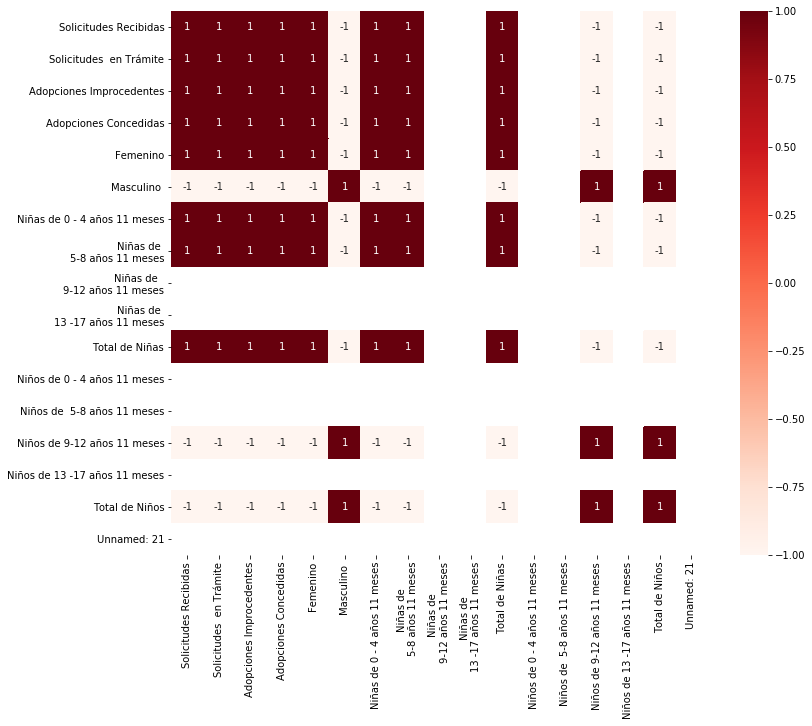

In [49]:
plt.figure(figsize=(12,10))
cor = doc.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [20]:
cor_target = abs(cor["Solicitudes Recibidas"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Solicitudes Recibidas           1.0
Solicitudes  en Trámite         1.0
Adopciones Improcedentes        1.0
Adopciones Concedidas           1.0
Femenino                        1.0
Masculino                       1.0
Niñas de 0 - 4 años 11 meses    1.0
Niñas de \n5-8 años 11 meses    1.0
Total de Niñas                  1.0
Niños de 9-12 años 11 meses     1.0
Total de Niños                  1.0
Name: Solicitudes Recibidas, dtype: float64

In [24]:
print(doc[['Adopciones Concedidas',"Adopciones Improcedentes"]].corr())
print(doc[["Adopciones Concedidas","Total de Niños"]].corr())

                          Adopciones Concedidas  Adopciones Improcedentes
Adopciones Concedidas                       1.0                       1.0
Adopciones Improcedentes                    1.0                       1.0
                       Adopciones Concedidas  Total de Niños
Adopciones Concedidas                    1.0            -1.0
Total de Niños                          -1.0             1.0


In [51]:

X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=True)

LSTAT      7.776912e-23
RM         1.979441e-18
DIS        6.013491e-13
PTRATIO    1.308835e-12
const      3.283438e-12
NOX        4.245644e-06
RAD        5.070529e-06
B          5.728592e-04
ZN         7.781097e-04
CRIM       1.086810e-03
TAX        1.111637e-03
CHAS       1.925030e-03
INDUS      7.382881e-01
AGE        9.582293e-01
dtype: float64

In [52]:
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [54]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [55]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 10
Desempeño con 10 características: 0.663581


In [56]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


In [57]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:10
Desempeño mediante la regularización Lasso: 0.702444
